In [1]:
pip install PIL

^C
Note: you may need to restart the kernel to use updated packages.


In [3]:
from PIL import Image
import os

def stitch_images_vertically(start, end, output_file):
    images = []

    # Read images from start to end (inclusive)
    for i in range(start, end + 1):
        filename = f"Set-01/{i}.bmp"
        if os.path.exists(filename):
            img = Image.open(filename)
            images.append(img)
        else:
            print(f"File {filename} not found. Skipping...")

    if not images:
        print("No images found. Exiting...")
        return

    # Ensure all images have the same width
    widths = [img.width for img in images]
    max_width = max(widths)

    # Resize images to have the same width (if necessary)
    resized_images = [img.resize((max_width, int(img.height * max_width / img.width))) if img.width != max_width else img for img in images]

    # Calculate total height for the output image
    total_height = sum(img.height for img in resized_images)

    # Create a new blank image with the total dimensions
    stitched_image = Image.new("RGB", (max_width, total_height))

    # Paste images one below the other
    y_offset = 0
    for img in resized_images:
        stitched_image.paste(img, (0, y_offset))
        y_offset += img.height

    # Save the resulting image
    stitched_image.save(output_file)
    print(f"Stitched image saved as {output_file}")

# Specify the range of images and output file
start_image = 3
end_image = 20
output_filename = "stitched_image.bmp"

stitch_images_vertically(start_image, end_image, output_filename)


Stitched image saved as stitched_image.bmp


In [3]:
import cv2

def panorama_stitching(images):
    """
    Stitches images into a panorama using OpenCV's Stitcher.
    """
    # Create a stitcher object
    stitcher = cv2.Stitcher_create()

    # Perform stitching
    status, stitched_image = stitcher.stitch(images)
    if status != cv2.Stitcher_OK:
        print(f"Error during stitching: {status}")
        return None
    return stitched_image

def hierarchical_panorama_stitching(images):
    """
    Perform hierarchical panorama stitching to handle large numbers of images.
    """
    while len(images) > 1:
        print(f"Number of images to stitch: {len(images)}")
        stitched_images = []
        for i in range(0, len(images) - 1, 2):
            print(f"Stitching images {i} and {i+1}")
            pair = [images[i], images[i+1]]
            stitched = panorama_stitching(pair)
            if stitched is not None:
                stitched_images.append(stitched)
        # If odd number of images, carry the last one forward
        if len(images) % 2 == 1:
            stitched_images.append(images[-1])
        images = stitched_images
    return images[0] if images else None

# Load the images
images = [cv2.imread(f"Set-01/{i}.bmp") for i in range(3, 5)]

# Remove None images (if any failed to load)
images = [img for img in images if img is not None]

# Perform hierarchical panorama stitching
stitched_image = hierarchical_panorama_stitching(images)

# Save the final stitched image
if stitched_image is not None:
    cv2.imwrite("final_panorama_stitched_image.bmp", stitched_image)
    print("Final panorama stitched image saved as 'final_panorama_stitched_image.bmp'")
else:
    print("Failed to stitch images.")


Number of images to stitch: 2
Stitching images 0 and 1
Final panorama stitched image saved as 'final_panorama_stitched_image.bmp'


In [4]:
print(images[0].shape)

(400, 1280, 3)


In [3]:
import numpy as np
image =cv2.imread('final_panorama_stitched_image.bmp')
def cylindrical_projection(image, focal_length):
    """
    Applies a cylindrical projection to an image.
    
    Parameters:
    - image: Input image.
    - focal_length: Focal length for the cylindrical projection.
    
    Returns:
    - Transformed image.
    """
    height, width = image.shape[:2]
    center_x, center_y = width // 2, height // 2

    # Output image (black background)
    cylindrical_image = np.zeros_like(image)

    for y in range(height):
        for x in range(width):
            # Convert to cylindrical coordinates
            theta = (x - center_x) / focal_length
            h = (y - center_y) / focal_length

            # Back-project to 2D image plane
            X = focal_length * np.tan(theta) + center_x
            Y = focal_length * h / (np.cos(theta) + 1e-6) + center_y

            if 0 <= int(X) < width and 0 <= int(Y) < height:
                cylindrical_image[y, x] = image[int(Y), int(X)]

    return cylindrical_image

# Apply cylindrical projection
focal_length = 500  # Adjust as needed
cylindrical_image = cylindrical_projection(image, focal_length)

# Save the result
cv2.imwrite("cylindrical_projection.jpg", cylindrical_image)


True

In [26]:
%pip install torch kornia opencv-python matplotlib




   ---------------------------------------- 0.0/899.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/899.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/899.4 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/899.4 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/899.4 kB ? eta -:--:--
   ---------------------- --------------- 524.3/899.4 kB 670.4 kB/s eta 0:00:01
   ---------------------- --------------- 524.3/899.4 kB 670.4 kB/s eta 0:00:01
   -------------------------------------- 899.4/899.4 kB 668.7 kB/s eta 0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   -------- ------------------------------- 0.3/1.3 MB ? eta -:--:--
   -------- ------------------------------- 0.3/1.3 MB ? eta -:--:--
   ---------------- ----------------------- 0.5/1.3 MB 728.2 kB/s eta 0:00:02
   ------------------------ --------------- 0.

In [28]:
import cv2
import numpy as np
import random

def panorama_stitching(images):
    """
    Stitches multiple images into a panorama.
    :param images: List of images to be stitched
    :return: The final stitched panorama
    """
    # Start with the first image
    stitched_img = images[0]

    # Iteratively stitch each subsequent image
    for i in range(1, len(images)):
        stitched_img = solution(stitched_img, images[i])
        print(i,i+1)
    
    return stitched_img

def solution(left_img, right_img):
    """
    Stitches two images using keypoints and RANSAC.
    """
    key_points1, descriptor1, key_points2, descriptor2 = get_keypoint(left_img, right_img)
    good_matches = match_keypoint(key_points1, key_points2, descriptor1, descriptor2)
    final_H = ransac(good_matches)

    rows1, cols1 = right_img.shape[:2]
    rows2, cols2 = left_img.shape[:2]

    points1 = np.float32([[0, 0], [0, rows1], [cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    points = np.float32([[0, 0], [0, rows2], [cols2, rows2], [cols2, 0]]).reshape(-1, 1, 2)
    points2 = cv2.perspectiveTransform(points, final_H)
    list_of_points = np.concatenate((points1, points2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

    H_translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]]).dot(final_H)

    output_img = cv2.warpPerspective(left_img, H_translation, (x_max - x_min, y_max - y_min))
    output_img[-y_min:rows1 + (-y_min), -x_min:cols1 + (-x_min)] = right_img
    return output_img
def get_keypoint(left_img, right_img):
    """
    Extracts keypoints and descriptors using SIFT.
    """
    l_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    r_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()

    key_points1, descriptor1 = sift.detectAndCompute(l_img, None)
    key_points2, descriptor2 = sift.detectAndCompute(r_img, None)

    return key_points1, descriptor1, key_points2, descriptor2


def match_keypoint(key_points1, key_points2, descriptor1, descriptor2):
    """
    Matches keypoints using k-nearest neighbors and Lowe's ratio test.
    """
    i = 0
    k = 2
    all_matches = []
    for d1 in descriptor1:
        dist = []
        j = 0
        for d2 in descriptor2:
            dist.append([i, j, np.linalg.norm(d1 - d2)])
            j += 1
        dist.sort(key=lambda x: x[2])
        all_matches.append(dist[:k])
        i += 1

    good_matches = []
    for m, n in all_matches:
        if m[2] < 0.75 * n[2]:
            left_pt = key_points1[m[0]].pt
            right_pt = key_points2[m[1]].pt
            good_matches.append([left_pt[0], left_pt[1], right_pt[0], right_pt[1]])
    return good_matches

def homography(points):
    """
    Computes a homography matrix from point correspondences.
    """
    A = []
    for pt in points:
        x, y = pt[0], pt[1]
        X, Y = pt[2], pt[3]
        A.append([x, y, 1, 0, 0, 0, -X * x, -X * y, -X])
        A.append([0, 0, 0, x, y, 1, -Y * x, -Y * y, -Y])

    A = np.array(A)
    _, _, vh = np.linalg.svd(A)
    H = vh[-1, :].reshape(3, 3)
    H = H / H[2, 2]
    return H

def ransac(good_pts):
    """
    Applies RANSAC to find the best homography matrix.
    """
    best_inliers = []
    final_H = []
    t = 5
    for _ in range(5000):
        random_pts = random.choices(good_pts, k=4)
        H = homography(random_pts)
        inliers = []
        for pt in good_pts:
            p = np.array([pt[0], pt[1], 1]).reshape(3, 1)
            p_1 = np.array([pt[2], pt[3], 1]).reshape(3, 1)
            Hp = np.dot(H, p)
            Hp = Hp / Hp[2]
            dist = np.linalg.norm(p_1 - Hp)

            if dist < t:
                inliers.append(pt)

        if len(inliers) > len(best_inliers):
            best_inliers, final_H = inliers, H
    return final_H

if __name__ == "__main__":
    # Load your images
    images1 = [cv2.imread(f"Set-01/{i}.bmp") for i in range(3, 12)]
    images2 = [cv2.imread(f"Set-01/{i}.bmp") for i in range(12, 21)]
    

    # Stitch all images
    panorama1 = panorama_stitching(images1)
    panorama2 = panorama_stitching(images2)
    

    # Save the final panorama
    cv2.imwrite('final_panoramabmp_part2.bmp', panorama2)
    cv2.imwrite('final_panoramabmp_part1.bmp', panorama1)
    
    print("Panorama saved as 'results/final_panorama.jpg'")


1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
Panorama saved as 'results/final_panorama.jpg'


In [19]:
import cv2
import numpy as np
import random

def panorama_stitching_hierarchical(images):
    """
    Hierarchically stitches images into a panorama.
    :param images: List of images to be stitched
    :return: The final stitched panorama
    """
    while len(images) > 1:
        stitched_images = []
        for i in range(0, len(images) - 1, 2):
            stitched_images.append(solution(images[i], images[i + 1]))
        
        if len(images) % 2 == 1:
            stitched_images.append(images[-1])
        images = stitched_images
    return images[0]

def solution(left_img, right_img):
    """
    Stitches two images using keypoints and RANSAC.
    """
    key_points1, descriptor1, key_points2, descriptor2 = get_keypoint(left_img, right_img)
    good_matches = match_keypoint(key_points1, key_points2, descriptor1, descriptor2)
    final_H = ransac(good_matches)

    rows1, cols1 = right_img.shape[:2]
    rows2, cols2 = left_img.shape[:2]

    points1 = np.float32([[0, 0], [0, rows1], [cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    points = np.float32([[0, 0], [0, rows2], [cols2, rows2], [cols2, 0]]).reshape(-1, 1, 2)
    points2 = cv2.perspectiveTransform(points, final_H)
    list_of_points = np.concatenate((points1, points2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

    H_translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]]).dot(final_H)

    output_img = cv2.warpPerspective(left_img, H_translation, (x_max - x_min, y_max - y_min))
    output_img[-y_min:rows1 + (-y_min), -x_min:cols1 + (-x_min)] = right_img
    return output_img

def get_keypoint(left_img, right_img):
    """
    Extracts keypoints and descriptors using SIFT.
    """
    l_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    r_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()

    key_points1, descriptor1 = sift.detectAndCompute(l_img, None)
    key_points2, descriptor2 = sift.detectAndCompute(r_img, None)

    return key_points1, descriptor1, key_points2, descriptor2

def match_keypoint(key_points1, key_points2, descriptor1, descriptor2):
    """
    Matches keypoints using k-nearest neighbors and Lowe's ratio test.
    """
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptor1, descriptor2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            left_pt = key_points1[m.queryIdx].pt
            right_pt = key_points2[m.trainIdx].pt
            good_matches.append([left_pt[0], left_pt[1], right_pt[0], right_pt[1]])
    return good_matches

def homography(points):
    """
    Computes a homography matrix from point correspondences.
    """
    A = []
    for pt in points:
        x, y = pt[0], pt[1]
        X, Y = pt[2], pt[3]
        A.append([x, y, 1, 0, 0, 0, -X * x, -X * y, -X])
        A.append([0, 0, 0, x, y, 1, -Y * x, -Y * y, -Y])

    A = np.array(A)
    _, _, vh = np.linalg.svd(A)
    H = vh[-1, :].reshape(3, 3)
    H = H / H[2, 2]
    return H

def ransac(good_pts):
    """
    Applies RANSAC to find the best homography matrix.
    """
    best_inliers = []
    final_H = []
    t = 5
    for _ in range(5000):
        random_pts = random.choices(good_pts, k=4)
        H = homography(random_pts)
        inliers = []
        for pt in good_pts:
            p = np.array([pt[0], pt[1], 1]).reshape(3, 1)
            p_1 = np.array([pt[2], pt[3], 1]).reshape(3, 1)
            Hp = np.dot(H, p)
            Hp = Hp / Hp[2]
            dist = np.linalg.norm(p_1 - Hp)

            if dist < t:
                inliers.append(pt)

        if len(inliers) > len(best_inliers):
            best_inliers, final_H = inliers, H
    return final_H

if __name__ == "__main__":
    # Load your images
    images = [cv2.imread(f"Set-01/{i}.bmp") for i in range(3, 21)]

    # Perform hierarchical stitching
    panorama = panorama_stitching_hierarchical(images)

    # Save the final panorama
    cv2.imwrite('final_panorama_hierarchical.bmp', panorama)
    print("Panorama saved as 'results/final_panorama_hierarchical.bmp'")


Panorama saved as 'results/final_panorama_hierarchical.bmp'


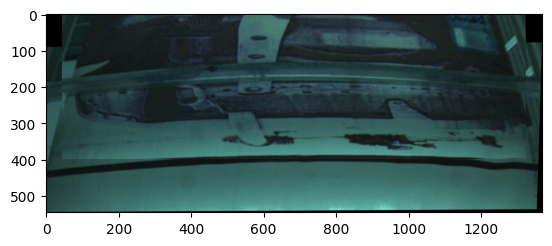

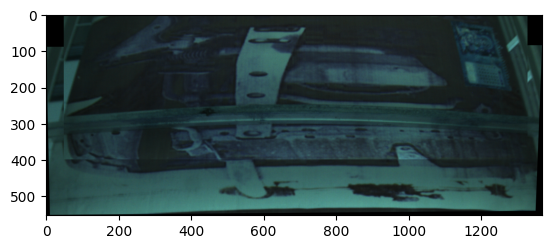

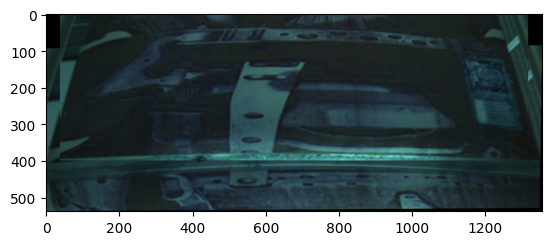

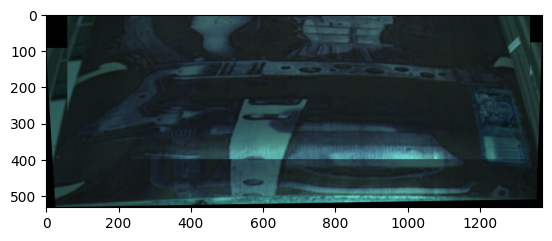

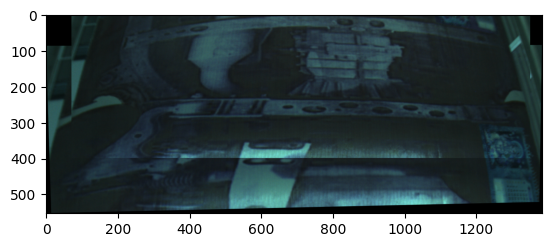

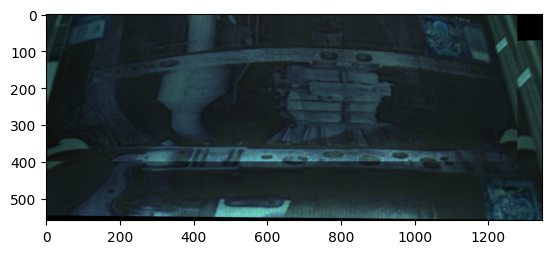

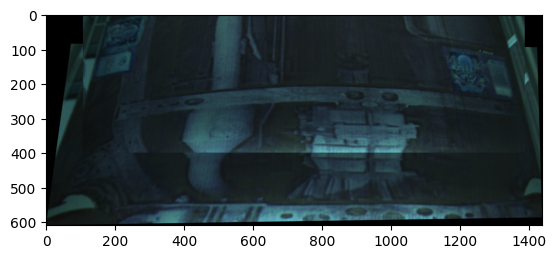

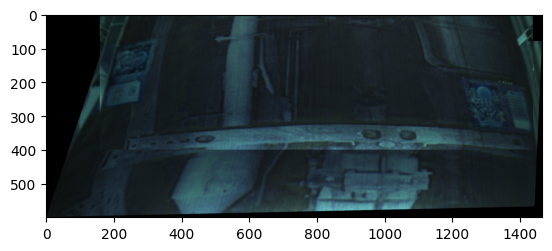

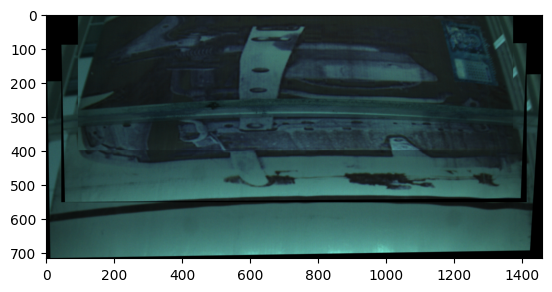

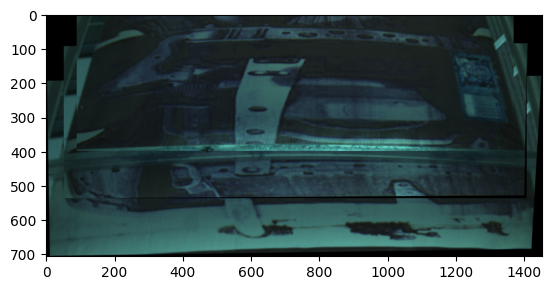

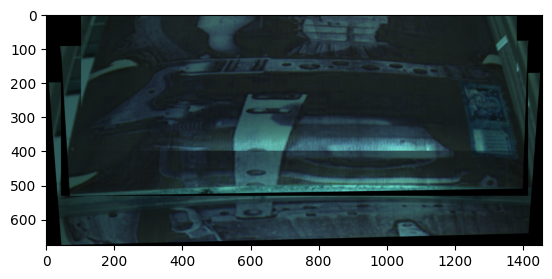

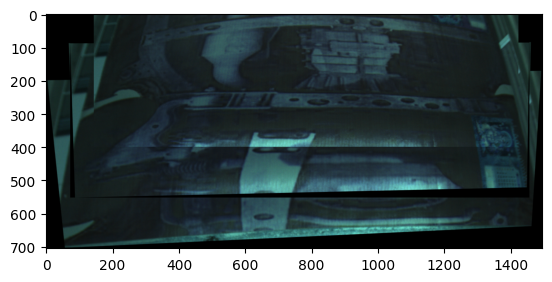

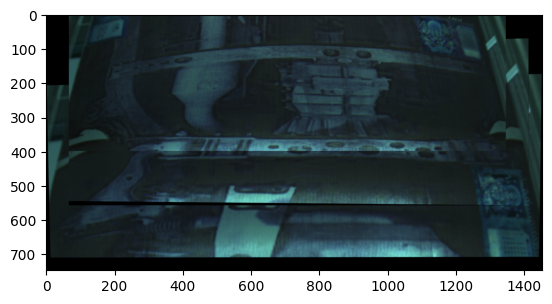

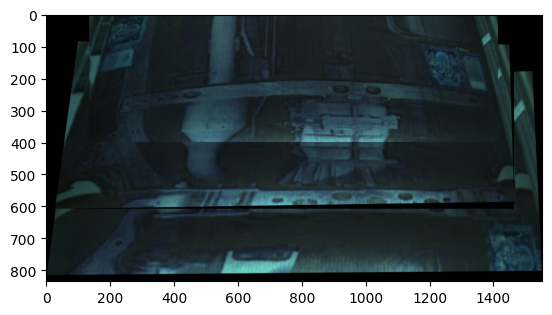

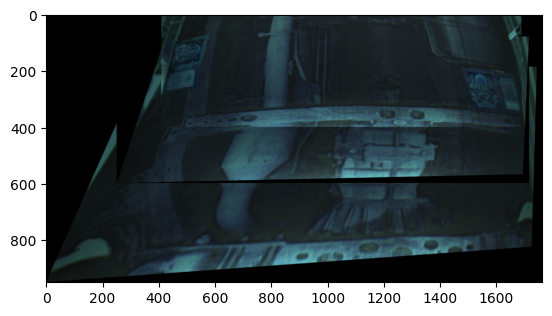

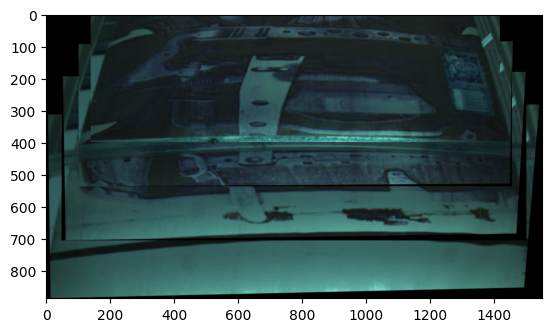

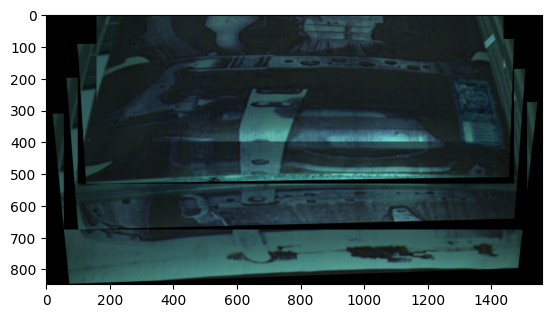

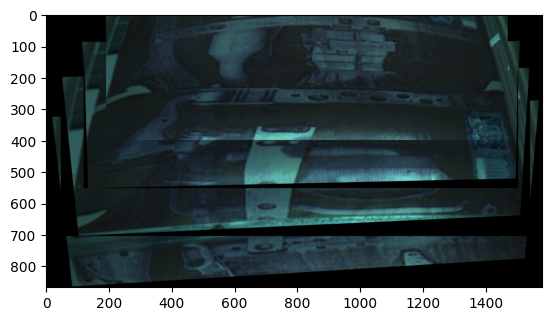

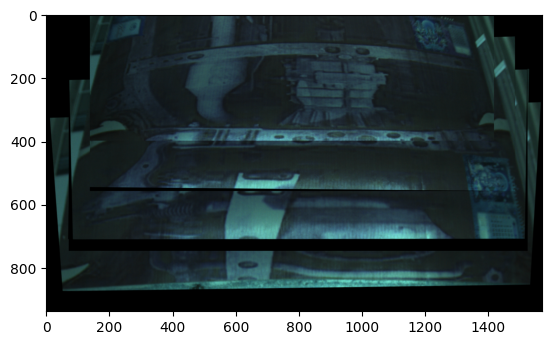

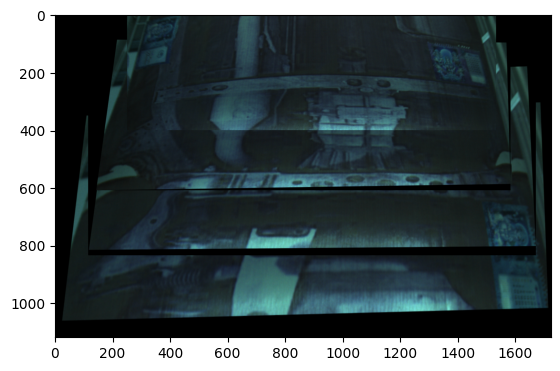

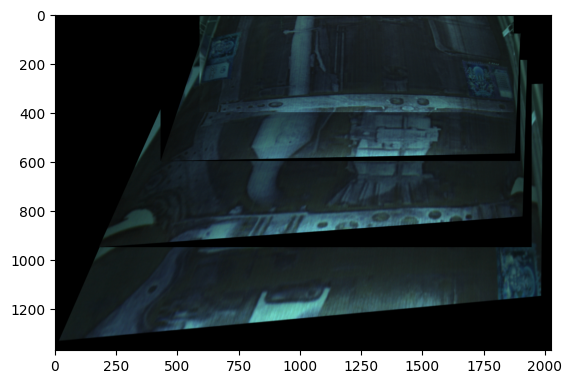

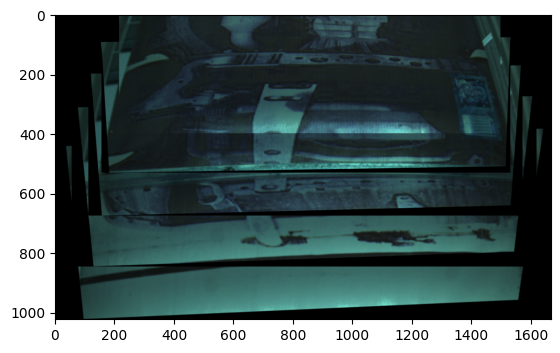

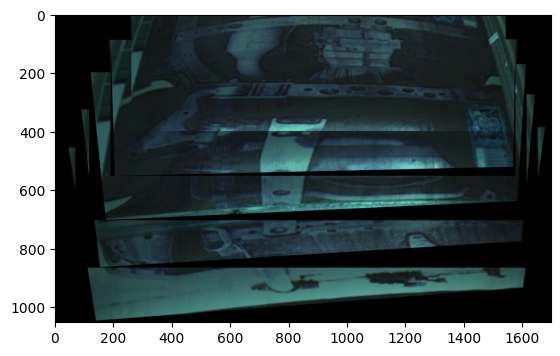

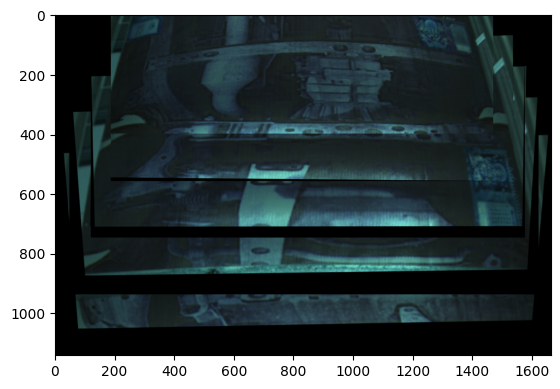

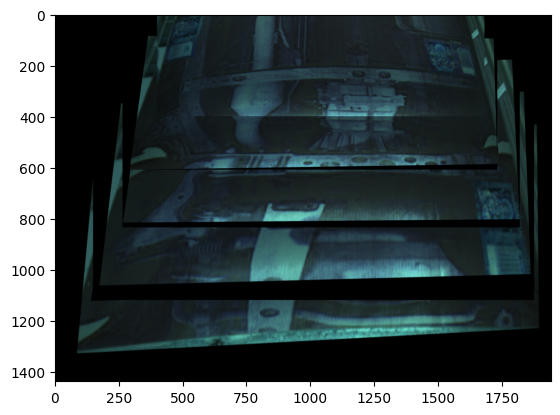

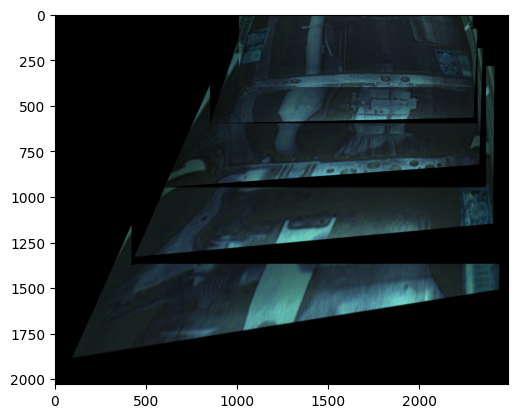

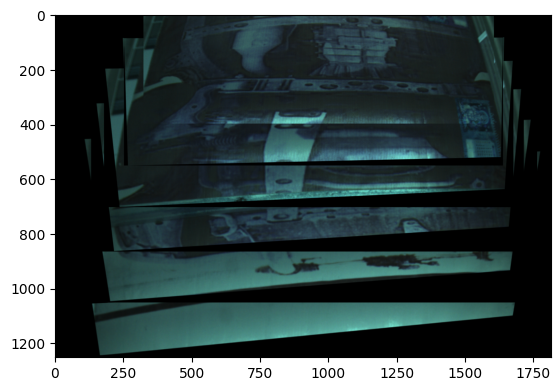

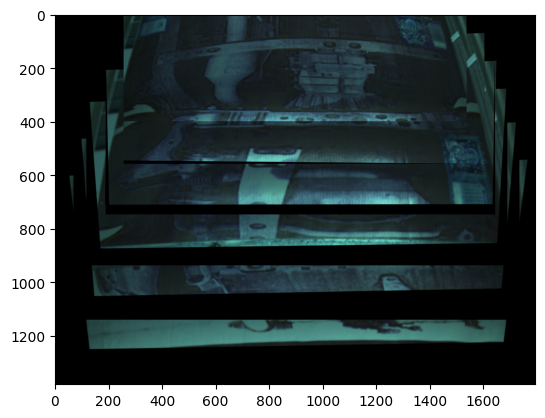

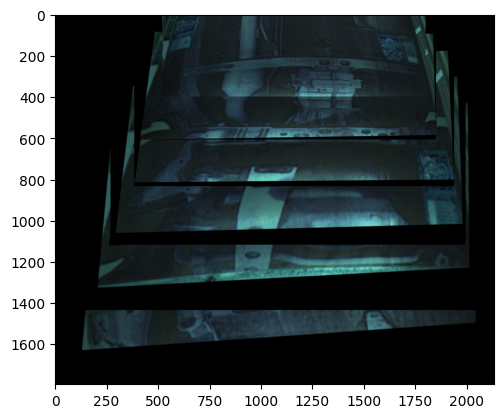

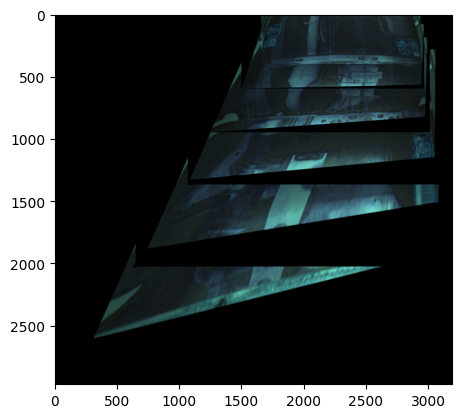

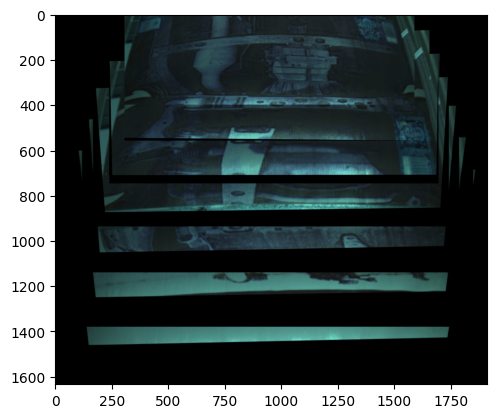

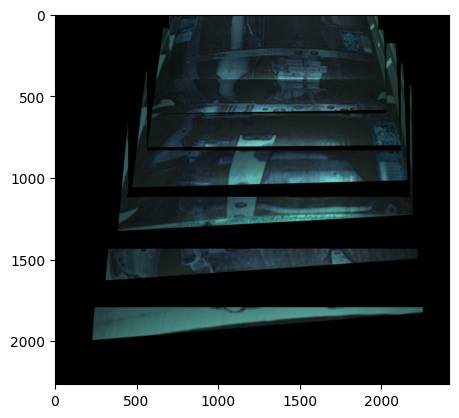

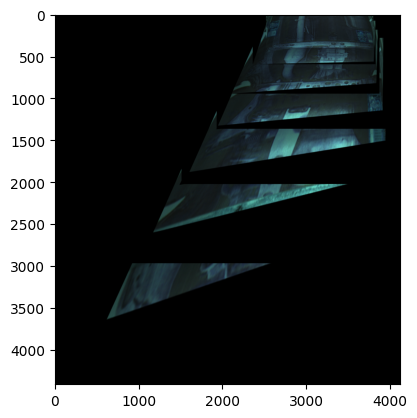

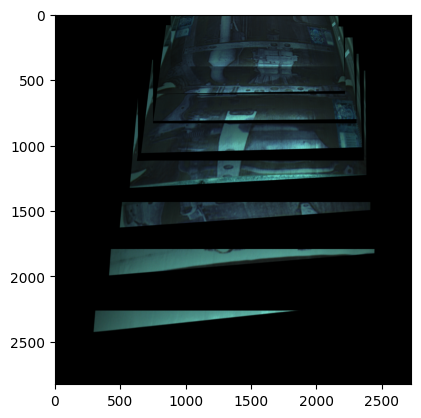

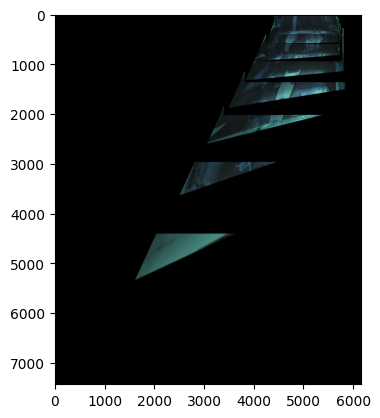

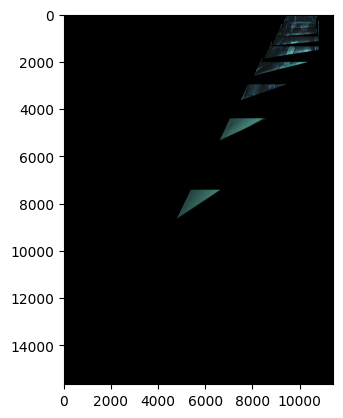

Panorama saved as 'results/final_panorama_hierarchical.bmp'


In [22]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
def panorama_stitching_hierarchical(images):
    """
    Hierarchically stitches images into a panorama.
    :param images: List of images to be stitched
    :return: The final stitched panorama
    """
    while len(images) > 1:
        stitched_images = []
        for i in range(0, len(images) - 1):
            stitched_image = solution(images[i], images[i + 1])
            stitched_images.append(stitched_image)
            plt.imshow (stitched_image)
            plt.show()
        # if len(images) % 2 == 1:
        #     stitched_images.append(images[-1])
        images = stitched_images
    return images[0]

def solution(left_img, right_img):
    """
    Stitches two images using keypoints and RANSAC.
    """
    key_points1, descriptor1, key_points2, descriptor2 = get_keypoint(left_img, right_img)
    good_matches = match_keypoint(key_points1, key_points2, descriptor1, descriptor2)
    final_H = ransac(good_matches)

    rows1, cols1 = right_img.shape[:2]
    rows2, cols2 = left_img.shape[:2]

    points1 = np.float32([[0, 0], [0, rows1], [cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    points = np.float32([[0, 0], [0, rows2], [cols2, rows2], [cols2, 0]]).reshape(-1, 1, 2)
    points2 = cv2.perspectiveTransform(points, final_H)
    list_of_points = np.concatenate((points1, points2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

    H_translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]]).dot(final_H)

    output_img = cv2.warpPerspective(left_img, H_translation, (x_max - x_min, y_max - y_min))
    output_img[-y_min:rows1 + (-y_min), -x_min:cols1 + (-x_min)] = right_img
    return output_img

def get_keypoint(left_img, right_img):
    """
    Extracts keypoints and descriptors using SIFT.
    """
    l_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    r_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()

    key_points1, descriptor1 = sift.detectAndCompute(l_img, None)
    key_points2, descriptor2 = sift.detectAndCompute(r_img, None)

    return key_points1, descriptor1, key_points2, descriptor2

def match_keypoint(key_points1, key_points2, descriptor1, descriptor2):
    """
    Matches keypoints using k-nearest neighbors and Lowe's ratio test.
    """
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptor1, descriptor2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            left_pt = key_points1[m.queryIdx].pt
            right_pt = key_points2[m.trainIdx].pt
            good_matches.append([left_pt[0], left_pt[1], right_pt[0], right_pt[1]])
    return good_matches

def homography(points):
    """
    Computes a homography matrix from point correspondences.
    """
    A = []
    for pt in points:
        x, y = pt[0], pt[1]
        X, Y = pt[2], pt[3]
        A.append([x, y, 1, 0, 0, 0, -X * x, -X * y, -X])
        A.append([0, 0, 0, x, y, 1, -Y * x, -Y * y, -Y])

    A = np.array(A)
    _, _, vh = np.linalg.svd(A)
    H = vh[-1, :].reshape(3, 3)
    H = H / H[2, 2]
    return H

def ransac(good_pts):
    """
    Applies RANSAC to find the best homography matrix.
    """
    best_inliers = []
    final_H = []
    t = 5
    for _ in range(5000):
        random_pts = random.choices(good_pts, k=4)
        H = homography(random_pts)
        inliers = []
        for pt in good_pts:
            p = np.array([pt[0], pt[1], 1]).reshape(3, 1)
            p_1 = np.array([pt[2], pt[3], 1]).reshape(3, 1)
            Hp = np.dot(H, p)
            Hp = Hp / Hp[2]
            dist = np.linalg.norm(p_1 - Hp)

            if dist < t:
                inliers.append(pt)

        if len(inliers) > len(best_inliers):
            best_inliers, final_H = inliers, H
    return final_H

if __name__ == "__main__":
    # Load your images
    images = [cv2.imread(f"Set-01/{i}.bmp") for i in range(3, 12)]

    # Perform hierarchical stitching
    panorama = panorama_stitching_hierarchical(images)

    # Save the final panorama
    cv2.imwrite('final_panorama_hierarchical_12.bmp', panorama)
    print("Panorama saved as 'results/final_panorama_hierarchical.bmp'")


In [27]:
import torch
import kornia as K
import matplotlib.pyplot as plt
from kornia.contrib import ImageStitcher
from kornia.feature import LoFTR
import cv2


def load_images(image_paths):
    """
    Loads and preprocesses images as PyTorch tensors.
    :param image_paths: List of image file paths
    :return: List of images as PyTorch tensors
    """
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        tensor_img = K.image_to_tensor(img, keepdim=False).float() / 255.0
        images.append(tensor_img)
    return images


def hierarchical_stitching(images):
    """
    Hierarchically stitches images using LoFTR and ImageStitcher.
    :param images: List of PyTorch tensors of images
    :return: Final stitched panorama as a PyTorch tensor
    """
    stitcher = ImageStitcher(LoFTR(pretrained="outdoor"), estimator="ransac")
    
    while len(images) > 1:
        stitched_images = []
        for i in range(0, len(images) - 1, 2):
            with torch.no_grad():
                stitched = stitcher(images[i], images[i + 1])
            stitched_images.append(stitched)
        if len(images) % 2 == 1:
            stitched_images.append(images[-1])  # Append the last unpaired image
        images = stitched_images
    return images[0]


if __name__ == "__main__":
    # Paths to images
    image_paths = [f"Set-01/{i}.bmp" for i in range(3, 7)]

    # Load and preprocess images
    imgs = load_images(image_paths)

    # Perform hierarchical stitching
    with torch.no_grad():
        panorama = hierarchical_stitching(imgs)

    # Convert the output tensor to an image
    panorama_img = K.tensor_to_image(panorama)

    # Display the panorama
    plt.figure(figsize=(20, 10))
    plt.imshow(panorama_img)
    plt.axis('off')
    plt.show()

    # Save the panorama
    cv2.imwrite('results/final_hierarchical_panorama_loftr.bmp', cv2.cvtColor(panorama_img, cv2.COLOR_RGB2BGR))
    print("Panorama saved as 'results/final_hierarchical_panorama_loftr.bmp'")


Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to C:\Users\rachi/.cache\torch\hub\checkpoints\loftr_outdoor.ckpt
  1%|▏         | 640k/44.2M [00:40<46:44, 16.3kB/s]


KeyboardInterrupt: 